In [ ]:
!pip install gymnasium
!pip install ale-py
!pip install "gymnasium[classic-control]"
!pip install "gymnasium[atari]"
!pip install torch

In [1]:
import gymnasium as gym
from IPython import display
import ale_py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Part 1 - CartPole-v1

Episode 0, Total Reward: 11.0, Moving Avg Reward: 11.00, Max Q-Value: 0.07
Episode 100, Total Reward: 53.0, Moving Avg Reward: 35.81, Max Q-Value: 1.69
Episode 200, Total Reward: 159.0, Moving Avg Reward: 69.18, Max Q-Value: 1.66
Episode 300, Total Reward: 108.0, Moving Avg Reward: 74.06, Max Q-Value: 11.43
Episode 400, Total Reward: 119.0, Moving Avg Reward: 113.43, Max Q-Value: 5.82
Episode 500, Total Reward: 138.0, Moving Avg Reward: 132.15, Max Q-Value: 1.22
Episode 600, Total Reward: 122.0, Moving Avg Reward: 171.45, Max Q-Value: 0.61
Episode 700, Total Reward: 176.0, Moving Avg Reward: 222.72, Max Q-Value: 0.90
Episode 800, Total Reward: 167.0, Moving Avg Reward: 229.51, Max Q-Value: 15.34
Episode 900, Total Reward: 182.0, Moving Avg Reward: 293.50, Max Q-Value: 14.76


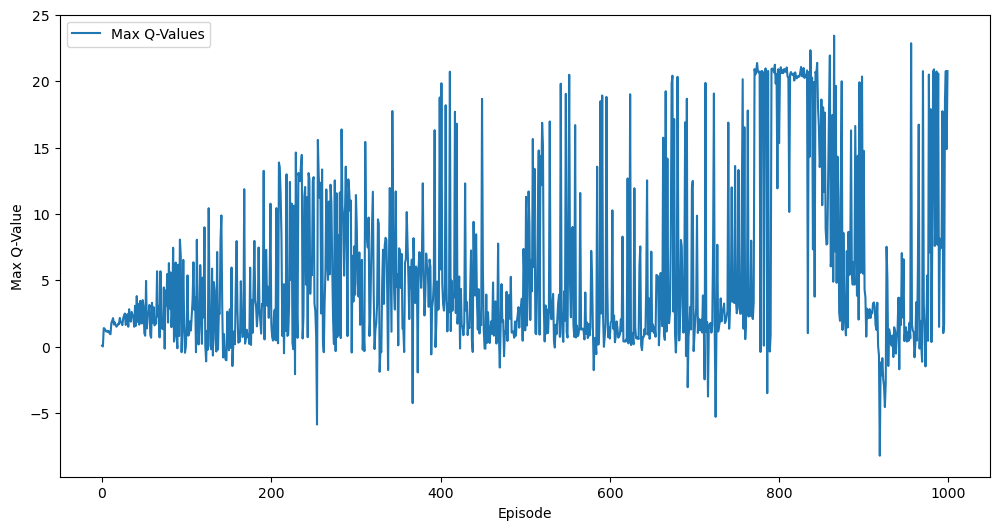

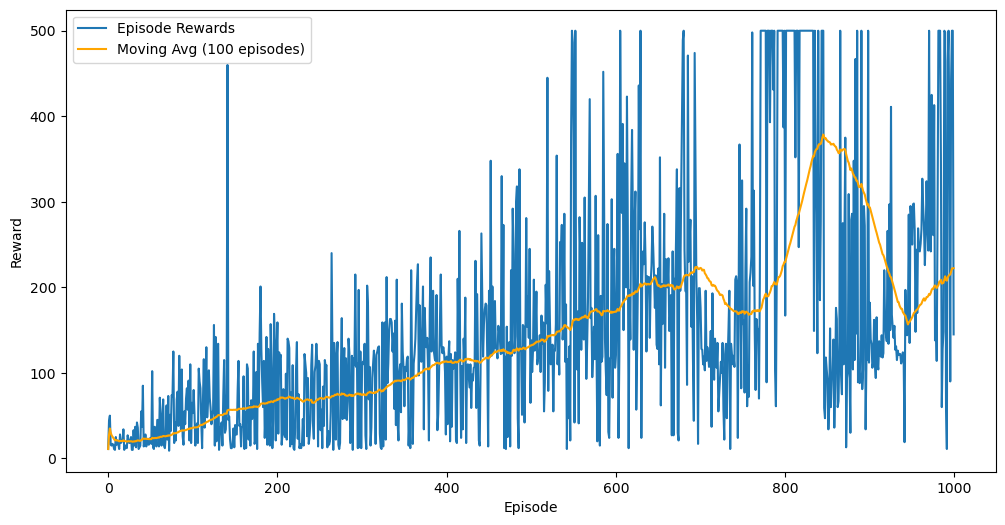

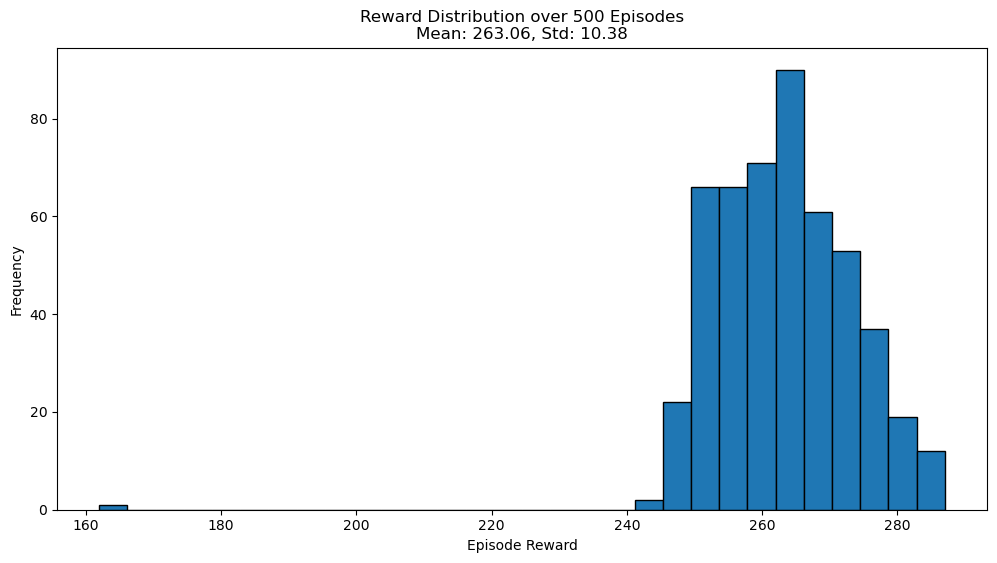

Mean Reward: 263.06, Std Deviation: 10.38


In [6]:
# Hyperparameters
HYPERPARAMETERS = {
    'input_dim': 4,
    'hidden_dim': 128,
    'output_dim': 2,
    'batch_size': 64,
    'gamma': 0.95,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'eps_decay': 0.995,
    'learning_rate': 0.001,
    'buffer_capacity': 10000,
    'num_episodes': 1000,
    'target_update_frequency': 10
}

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Experience Replay Buffer
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Epsilon-greedy action selection
def select_action(state, policy_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        q_values = policy_net(state)
        return q_values.argmax().item()

# Training the DQN algorithm
def train_dqn(env, policy_net, target_net, optimizer, memory, hyperparams):
    episode_rewards = []
    moving_avg_rewards = []
    max_q_values = []
    reward_history = deque(maxlen=100)
    epsilon = hyperparams['eps_start']

    for episode in range(hyperparams['num_episodes']):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0

        done = False
        while not done:
            action = select_action(state, policy_net, epsilon, env.action_space.n)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            memory.push(state, action, reward, next_state, done)

            if len(memory) >= hyperparams['batch_size']:
                optimize_model(policy_net, target_net, optimizer, memory, hyperparams['batch_size'], hyperparams['gamma'])

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)
        reward_history.append(total_reward)
        moving_avg_rewards.append(np.mean(reward_history))

        # Record the maximum Q-value for this episode
        with torch.no_grad():
            q_values = policy_net(state)
            max_q_value = q_values.max().item()
            max_q_values.append(max_q_value)

        epsilon = max(hyperparams['eps_end'], epsilon * hyperparams['eps_decay'])

        if episode % 100 == 0:
            print(f'Episode {episode}, Total Reward: {total_reward}, Moving Avg Reward: {np.mean(reward_history):.2f}, Max Q-Value: {max_q_value:.2f}')

        # Update target network periodically
        if episode % hyperparams['target_update_frequency'] == 0:
            update_target_network(policy_net, target_net)

    return episode_rewards, moving_avg_rewards, max_q_values

# Optimize the model
def optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Experience(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
    next_state_batch = torch.cat(batch.next_state)
    done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)

    current_q_values = policy_net(state_batch).gather(1, action_batch)
    next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
    expected_q_values = reward_batch + (1 - done_batch) * gamma * next_q_values

    loss = nn.MSELoss()(current_q_values, expected_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Update target network
def update_target_network(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Plot the maximum Q-values versus the number of training episodes
def plot_max_q_values(max_q_values):
    plt.figure(figsize=(12, 6))
    plt.plot(max_q_values, label='Max Q-Values')
    plt.xlabel('Episode')
    plt.ylabel('Max Q-Value')
    plt.legend()
    plt.show()

# Plot the episode rewards versus the number of training episodes, overlay with the moving average
def plot_rewards(episode_rewards, moving_avg_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Rewards')
    plt.plot(moving_avg_rewards, label='Moving Avg (100 episodes)', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

# Roll out 500 episodes using the trained model and plot the histogram
def rollout_and_plot_histogram(env, policy_net, num_episodes=500):
    rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        episode_reward = 0
        done = False
        while not done:
            action = select_action(state, policy_net, epsilon=0.0, n_actions=env.action_space.n)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    plt.figure(figsize=(12, 6))
    plt.hist(rewards, bins=30, edgecolor='black')
    plt.xlabel('Episode Reward')
    plt.ylabel('Frequency')
    plt.title(f'Reward Distribution over {num_episodes} Episodes\nMean: {mean_reward:.2f}, Std: {std_reward:.2f}')
    plt.show()

    return mean_reward, std_reward

# Main training script
if __name__ == "__main__":
    env = gym.make('CartPole-v1')

    input_dim = HYPERPARAMETERS['input_dim']
    hidden_dim = HYPERPARAMETERS['hidden_dim']
    output_dim = HYPERPARAMETERS['output_dim']

    policy_net = QNetwork(input_dim, hidden_dim, output_dim)
    target_net = QNetwork(input_dim, hidden_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=HYPERPARAMETERS['learning_rate'])
    memory = ReplayBuffer(capacity=HYPERPARAMETERS['buffer_capacity'])

    episode_rewards, moving_avg_rewards, max_q_values = train_dqn(env, policy_net, target_net, optimizer, memory, HYPERPARAMETERS)

    plot_max_q_values(max_q_values)
    plot_rewards(episode_rewards, moving_avg_rewards)

    mean_reward, std_reward = rollout_and_plot_histogram(env, policy_net)
    print(f'Mean Reward: {mean_reward:.2f}, Std Deviation: {std_reward:.2f}')

# Part 2 - MsPacman-v0

Episode 0, Total Reward: 250.0, Moving Avg Reward: 250.00, Max Q-Value: 16112.56
Episode 10, Total Reward: 350.0, Moving Avg Reward: 250.91, Max Q-Value: 16970.26
Episode 20, Total Reward: 270.0, Moving Avg Reward: 239.52, Max Q-Value: 15798.74
Episode 30, Total Reward: 230.0, Moving Avg Reward: 239.68, Max Q-Value: 16292.72
Episode 40, Total Reward: 240.0, Moving Avg Reward: 270.73, Max Q-Value: 16118.25
Episode 50, Total Reward: 480.0, Moving Avg Reward: 270.78, Max Q-Value: 16097.04
Episode 60, Total Reward: 250.0, Moving Avg Reward: 283.77, Max Q-Value: 16511.52
Episode 70, Total Reward: 370.0, Moving Avg Reward: 297.18, Max Q-Value: 16354.07
Episode 80, Total Reward: 240.0, Moving Avg Reward: 314.44, Max Q-Value: 17207.46
Episode 90, Total Reward: 360.0, Moving Avg Reward: 342.09, Max Q-Value: 16896.14
Episode 100, Total Reward: 310.0, Moving Avg Reward: 341.10, Max Q-Value: 17143.83
Episode 110, Total Reward: 440.0, Moving Avg Reward: 354.20, Max Q-Value: 17202.80
Episode 120, To

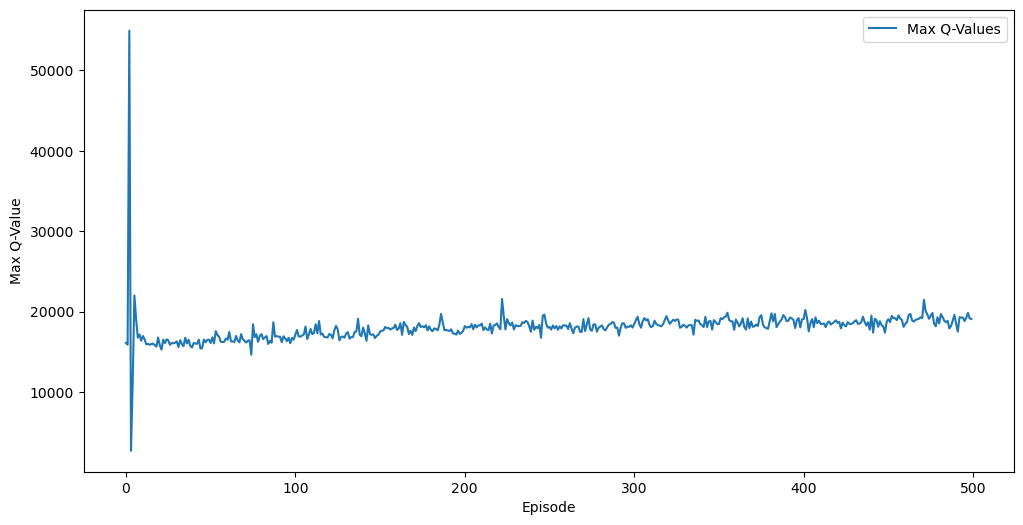

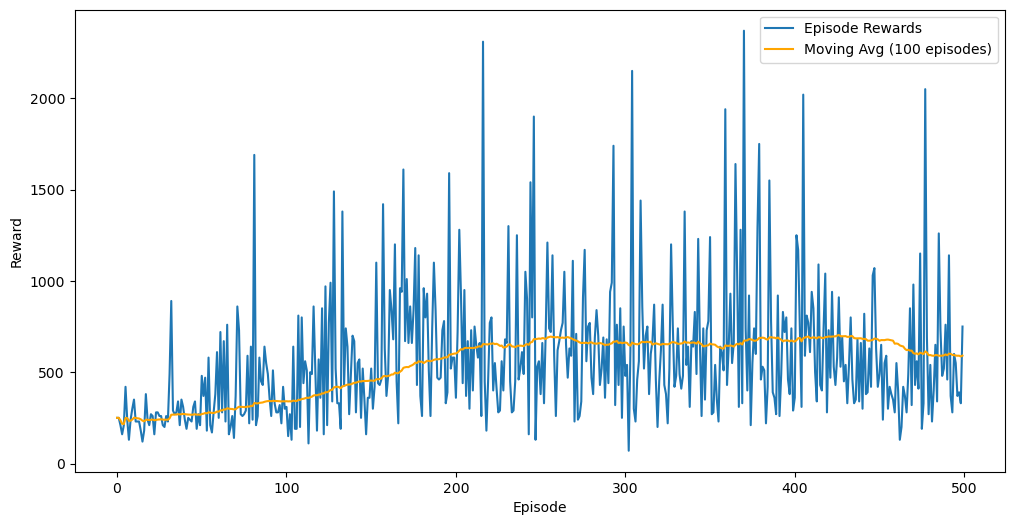

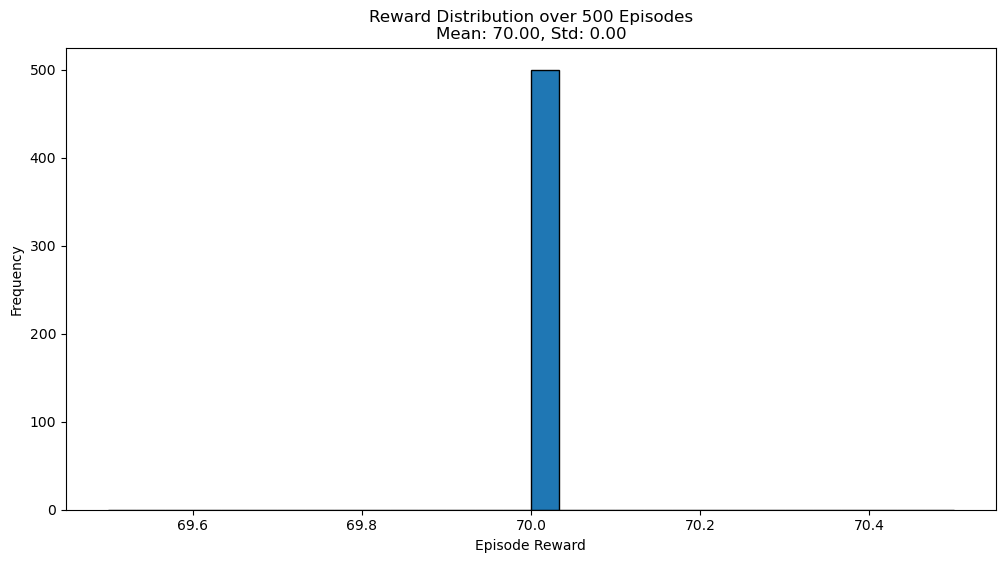

Mean Reward: 70.00, Std Deviation: 0.00


In [29]:
from torch.amp import GradScaler, autocast

# Hyperparameters
HYPERPARAMETERS = {
    'input_dim': (1, 88, 80),  # Shape: (channels, height, width)
    'hidden_dim': 512,
    'output_dim': 9,  # MsPacman has 9 actions
    'batch_size': 32,
    'gamma': 0.99,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'eps_decay': 0.995,
    'learning_rate': 0.01,
    'buffer_capacity': 500,
    'num_episodes': 500,
    'target_update_frequency': 50,
    'n_steps': 50  # Number of steps to process in one batch
}

# Preprocess function for MsPacman-v0
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]  # crop and downsize
    img = img.sum(axis=2)  # to greyscale
    img[img == mspacman_color] = 0  # Improve contrast
    img = (img // 3 - 128).astype(np.int8)  # normalize from -128 to 127
    return img.reshape(88, 80, 1)  # Shape: (height, width, channels)

class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim[1] * input_dim[2], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Experience Replay Buffer
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Epsilon-greedy action selection
def select_action(state, policy_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        q_values = policy_net(state.to(device))
        return q_values.argmax().item()

# Training the DQN algorithm
def train_dqn(env, policy_net, target_net, optimizer, memory, hyperparams, scaler):
    episode_rewards = []
    moving_avg_rewards = []
    max_q_values = []
    reward_history = deque(maxlen=100)
    epsilon = hyperparams['eps_start']

    for episode in range(hyperparams['num_episodes']):
        state, _ = env.reset()
        state = preprocess_observation(state)
        state = torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        total_reward = 0

        done = False
        step_count = 0

        while not done:
            # Collect n_steps data
            states, actions, rewards, next_states, dones = [], [], [], [], []
            for _ in range(hyperparams['n_steps']):
                action = select_action(state, policy_net, epsilon, env.action_space.n)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state = preprocess_observation(next_state)
                next_state = torch.tensor(next_state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

                states.append(state.cpu())
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state.cpu())
                dones.append(done)

                state = next_state
                total_reward += reward
                step_count += 1

                if done:
                    break

            # Store n_steps data in replay buffer
            for i in range(len(states)):
                memory.push(states[i], actions[i], rewards[i], next_states[i], dones[i])

            if len(memory) >= hyperparams['batch_size']:
                optimize_model(policy_net, target_net, optimizer, memory, hyperparams['batch_size'], hyperparams['gamma'], scaler)

        episode_rewards.append(total_reward)
        reward_history.append(total_reward)
        moving_avg_rewards.append(np.mean(reward_history))

        with torch.no_grad():
            q_values = policy_net(state)
            max_q_value = q_values.max().item()
            max_q_values.append(max_q_value)

        epsilon = max(hyperparams['eps_end'], epsilon * hyperparams['eps_decay'])

        if episode % 10 == 0:
            print(f'Episode {episode}, Total Reward: {total_reward}, Moving Avg Reward: {np.mean(reward_history):.2f}, Max Q-Value: {max_q_value:.2f}')

        if episode % hyperparams['target_update_frequency'] == 0:
            update_target_network(policy_net, target_net)

    return episode_rewards, moving_avg_rewards, max_q_values

def optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma, scaler):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Experience(*zip(*transitions))

    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
    next_state_batch = torch.cat(batch.next_state).to(device)
    done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

    with autocast(device_type=device.type):
        current_q_values = policy_net(state_batch).gather(1, action_batch)
        next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
        expected_q_values = reward_batch + (1 - done_batch) * gamma * next_q_values
        loss = nn.MSELoss()(current_q_values, expected_q_values)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

# Update target network
def update_target_network(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Plot the maximum Q-values versus the number of training episodes
def plot_max_q_values(max_q_values):
    plt.figure(figsize=(12, 6))
    plt.plot(max_q_values, label='Max Q-Values')
    plt.xlabel('Episode')
    plt.ylabel('Max Q-Value')
    plt.legend()
    plt.show()

# Plot the episode rewards versus the number of training episodes, overlay with the moving average
def plot_rewards(episode_rewards, moving_avg_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Rewards')
    plt.plot(moving_avg_rewards, label='Moving Avg (100 episodes)', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

# Roll out 500 episodes using the trained model and plot the histogram
def rollout_and_plot_histogram(env, policy_net, num_episodes=500):
    rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state = preprocess_observation(state)
        state = torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        episode_reward = 0
        done = False
        while not done:
            action = select_action(state, policy_net, epsilon=0.0, n_actions=env.action_space.n)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_observation(next_state)
            next_state = torch.tensor(next_state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    plt.figure(figsize=(12, 6))
    plt.hist(rewards, bins=30, edgecolor='black')
    plt.xlabel('Episode Reward')
    plt.ylabel('Frequency')
    plt.title(f'Reward Distribution over {num_episodes} Episodes\nMean: {mean_reward:.2f}, Std: {std_reward:.2f}')
    plt.show()

    return mean_reward, std_reward

# Main training script
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('ALE/MsPacman-v5')  # Try this first; if it fails, use 'MsPacman-v0'

    input_dim = HYPERPARAMETERS['input_dim']
    hidden_dim = HYPERPARAMETERS['hidden_dim']
    output_dim = HYPERPARAMETERS['output_dim']

    policy_net = QNetwork(input_dim, hidden_dim, output_dim).to(device)
    target_net = QNetwork(input_dim, hidden_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=HYPERPARAMETERS['learning_rate'])
    memory = ReplayBuffer(capacity=HYPERPARAMETERS['buffer_capacity'])

    episode_rewards, moving_avg_rewards, max_q_values = train_dqn(env, policy_net, target_net, optimizer, memory, HYPERPARAMETERS, GradScaler())

    plot_max_q_values(max_q_values)
    plot_rewards(episode_rewards, moving_avg_rewards)

    mean_reward, std_reward = rollout_and_plot_histogram(env, policy_net)
    print(f'Mean Reward: {mean_reward:.2f}, Std Deviation: {std_reward:.2f}')